In [1]:
#@title Load a Random Metada ECG Record
import os
import wfdb
import numpy as np

QTDB_DATA_PATH = 'qt-database-1.0.0'

qtdb_pathology_mapping = {
  'sel123': 'MIT-BIH Arrhythmia',
  'sel233': 'MIT-BIH Arrhythmia',
  'sel302': 'MIT-BIH ST Change',
  'sel307': 'MIT-BIH ST Change',
  'sel820': 'MIT-BIH Supraventricular Arrhythmia',
  'sel853': 'MIT-BIH Supraventricular Arrhythmia',
  'sel16420': 'MIT-BIH Normal Sinus Rhythm',
  'sel16795': 'MIT-BIH Normal Sinus Rhythm',
  'sele0106': 'European ST-T',
  'sele0121': 'European ST-T',
  'sel32': 'Sudden Death (BIH)',
  'sel49': 'Sudden Death (BIH)',
  'sel14046': 'MIT-BIH Long-Term ECG',
  'sel15814': 'MIT-BIH Long-Term ECG'
}

# Randomly select a record from dict
record = np.random.choice(list(qtdb_pathology_mapping.keys()))

# File path
record_path = os.path.join(QTDB_DATA_PATH, str(record))

# load amplitude
signals, fields = wfdb.rdsamp(record_path)

# load delineation annotation
ann_samples = []
ann_symbols = []
channel_names = ['pu0', 'pu1']
for c in channel_names:
  ann = wfdb.rdann(record_path, extension=c)
  ann_samples.append(ann.sample)
  ann_symbols.append(ann.symbol)

print('Signal:', type(signals), signals.shape, signals.dtype)
print()

for key, value in fields.items():
  print(key, value)
print()

print('Annotation:', len(ann_samples), len(ann_symbols))

Signal: <class 'numpy.ndarray'> (225000, 2) float64

fs 250
sig_len 225000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['MLII', 'V1']
comments ['57 M 1682 654 x2', 'Dilantin', 'The PVCs are multiform.', 'Produced by xform from record 233, beginning at 0']

Annotation: 2 2


In [2]:
#@title Symbol-Sample to Densed Representation
import numpy as np

# Remapper b->0, N->1, t->2, p->3: This is same as Entities in the context of Named Entity Recognition
mapper = {
  'b': 0, # Baseline
  'N': 1, # QRS
  't': 2, # T
  'p': 3  # P
}

# 12-lead delineation annotator
delineation = []
for chnl_idx in range(2):

  label_encoded = []
  labeler = 'b' # baseline
  k = 0
  for i in range(fields['sig_len']):
    if i in ann_samples[chnl_idx]:
      labeler = ann_symbols[chnl_idx][k]
      if labeler == '(': # onset
        j = k
        labeler = ann_symbols[chnl_idx][j]
        while labeler == '(' or labeler == ')':
          j += 1
          labeler = ann_symbols[chnl_idx][j]
      elif labeler == ')': # offset
        labeler = 'b'

      k += 1

    label_encoded.append(mapper[labeler])

  delineation.append(label_encoded)

delineation = np.array(delineation).astype(np.uint8)

print(delineation[0])

[0 0 0 ... 0 0 0]


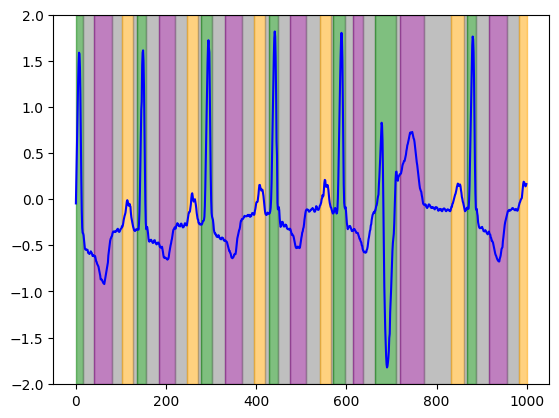

In [3]:
#@title Plot the Example of Signal and Delineation in a Rhythm
from visualizer import plot_delineation

start = np.random.randint(0, fields['sig_len'] - 1000)
stop = start + 1000

chnl_idx = 0
plot_delineation(signals[start:stop, chnl_idx], delineation[chnl_idx][start:stop])

In [4]:
# #@title Iterate for all Records for Symbol-Sample to Densed Representation (WARNING: LONG RUNTIME)

# ss_filename = 'qtdb_unseen_delineation_raw.pkl'

# if not os.path.exists(ss_filename):

#   data_to_collect = dict()
#   for record in qtdb_pathology_mapping.keys():
    
#     # File path
#     record_path = os.path.join(QTDB_DATA_PATH, str(record))

#     # load amplitude
#     signals, fields = wfdb.rdsamp(record_path)

#     # load delineation annotation
#     ann_samples = []
#     ann_symbols = []
#     channel_names = ['pu0', 'pu1']
#     for l in channel_names:
#       ann = wfdb.rdann(record_path, extension=l)
#       ann_samples.append(ann.sample)
#       ann_symbols.append(ann.symbol)
    
#     # 12-lead delineation annotator
#     delineation = []
#     for chnl_idx in range(2):

#       label_encoded = []
#       labeler = 'b' # baseline
#       k = 0
#       for i in range(fields['sig_len']):
#         if i in ann_samples[chnl_idx]:
#           labeler = ann_symbols[chnl_idx][k]
#           if labeler == '(': # onset
#             j = k
#             labeler = ann_symbols[chnl_idx][j]
#             while labeler == '(' or labeler == ')':
#               j += 1
#               try:
#                 labeler = ann_symbols[chnl_idx][j]
#               except Exception as e: # Unknow error, sometimes index out of range
#                 print('Error:', e, 'at', record, chnl_idx, i, j)
#                 break
#           elif labeler == ')': # offset
#             labeler = 'b'

#           k += 1

#         try:
#           label_encoded.append(mapper[labeler])
#         except:
#           label_encoded.append(0)

#       delineation.append(label_encoded)
#     delineation = np.array(delineation).astype(np.uint8)

#     data_to_collect[record] = {
#       'signals': signals,
#       'fields': fields,
#       'delineation': delineation
#     }

In [5]:
#@title Save the Symbol-Sample to Densed Representation in a Pickle File
import pickle

ss_filename = 'qtdb_unseen_delineation_raw.pkl'

# save
# with open(ss_filename, 'wb') as f:
#   pickle.dump(data_to_collect, f)

# load
with open(ss_filename, 'rb') as f: # still float64
  qtdb_delineation_raw = pickle.load(f)

In [6]:
#@title Find the Minimum from Maximum Length of Signal across all Records for Truncation Reference
max_len = []
for record, data in qtdb_delineation_raw.items():
  max_len.append(data['fields']['sig_len'])

print('Max:', max(max_len))
truncate_len = min(max_len)
print('Truncate:', truncate_len)

Max: 225000
Truncate: 224993


In [7]:
# #@title Batching Data for Denoiser Inference

# filename = 'qtdb_delineation_raw_batched.npz'
# if not os.path.exists(filename):
#   id_ref = []
#   amplitude_tensor = []
#   delineation_tensor = []
#   lead_ref_tensor = []

#   for record, data in qtdb_delineation_raw.items():
#     amplitude = []
#     delineation = []
#     lead_ref = []
#     for lead_idx in range(2):
#       s = data['signals'][:, lead_idx][:truncate_len]
#       d = data['delineation'][lead_idx][:truncate_len]
#       l = data['fields']['sig_name'][lead_idx]

#       amplitude.append(s)
#       delineation.append(d)
#       lead_ref.append(l)

#     id_ref.append(record)  
#     amplitude_tensor.append(amplitude)
#     delineation_tensor.append(delineation)
#     lead_ref_tensor.append(lead_ref)

#   id_ref = np.array(id_ref)
#   amplitude_tensor = np.array(amplitude_tensor)
#   delineation_tensor = np.array(delineation_tensor)
#   lead_ref_tensor = np.array(lead_ref_tensor)

# amplitude_tensor.shape, delineation_tensor.shape, id_ref.shape, lead_ref_tensor.shape, amplitude_tensor.dtype, delineation_tensor.dtype, id_ref.dtype, lead_ref_tensor.dtype

In [8]:
#@title Save Batched Tensor

filename = 'qtdb_delineation_raw_batched.npz'

# Save npz
# np.savez(filename, id_ref=id_ref, amplitude_tensor=amplitude_tensor, delineation_tensor=delineation_tensor, lead_ref_tensor=lead_ref_tensor)

# Laod back
data = np.load(filename)
id_ref = data['id_ref']
amplitude_tensor = data['amplitude_tensor']
delineation_tensor = data['delineation_tensor']
lead_ref_tensor = data['lead_ref_tensor']

amplitude_tensor.shape, delineation_tensor.shape, id_ref.shape, lead_ref_tensor.shape, amplitude_tensor.dtype, delineation_tensor.dtype, id_ref.dtype, lead_ref_tensor.dtype

((14, 2, 224993),
 (14, 2, 224993),
 (14,),
 (14, 2),
 dtype('float64'),
 dtype('uint8'),
 dtype('<U8'),
 dtype('<U4'))

In [9]:
#@title Reshape to (Batch, Time) for Inference

origin_shape = amplitude_tensor.shape
amplitude_tensor_batched = amplitude_tensor.reshape(-1, amplitude_tensor.shape[-1])
delineation_tensor_batched = delineation_tensor.reshape(-1, delineation_tensor.shape[-1])

amplitude_tensor_batched.shape, delineation_tensor_batched.shape

((28, 224993), (28, 224993))

In [10]:
#@title Perform Inference for Denoiser and Delineator
from end_to_end_inferencer import infer

"""
  Due to the limitation of the runtime, the inference is not performed here. Instead, the inference is performed in the kaggle notebook.
  https://www.kaggle.com/code/wawanikhwan/qtdb-unseen-eval-ecg-delineation-80hz-256winsize
"""

# from end_to_end_inferencer import infer
# X_pred, y_pred = infer(amplitude_tensor_batched, 250)

# print(amplitude_tensor_batched.shape, delineation_tensor_batched.shape)
# print(X_pred.shape, y_pred.shape, X_pred.dtype, y_pred.dtype)

'\n  Due to the limitation of the runtime, the inference is not performed here. Instead, the inference is performed in the kaggle notebook.\n  https://www.kaggle.com/code/wawanikhwan/qtdb-unseen-eval-ecg-delineation-80hz-256winsize?scriptVersionId=211919666\n'

In [11]:
#@title Reshape back to Original Shape

# X_gt = amplitude_tensor_batched.reshape(origin_shape)
# y_gt = delineation_tensor_batched.reshape(origin_shape)
# X_pred = X_pred.reshape(origin_shape)
# y_pred = y_pred.reshape(origin_shape)

In [10]:
#@title Save Tensor for Eval

exp_name = 'delineator_noatrial_d128_80hz_256winsize_latestmodel' # from kaggle notebook

# np.savez(
#     f'qtdb_pred_for_eval_{exp_name}.npz',
#     X_gt=X_gt,
#     y_gt=y_gt.astype(np.uint8),
#     X_pred=X_pred,
#     y_pred=y_pred.astype(np.uint8)
# )

# load back
data = np.load(f'qtdb_pred_for_eval_{exp_name}.npz')
X_gt = data['X_gt']
y_gt = data['y_gt']
X_pred = data['X_pred']
y_pred = data['y_pred']

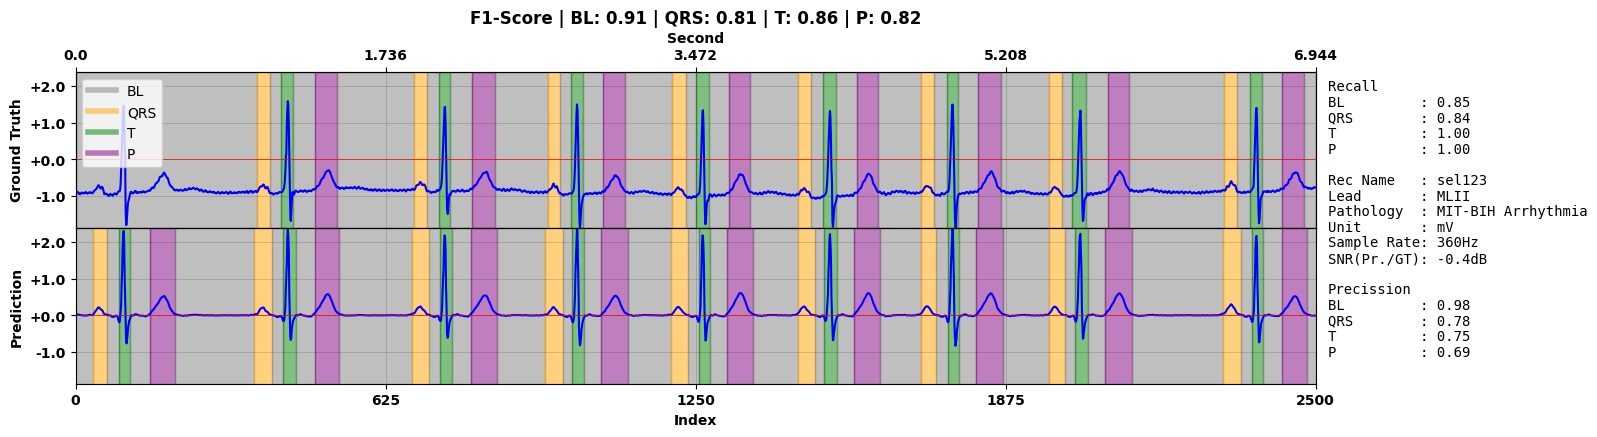

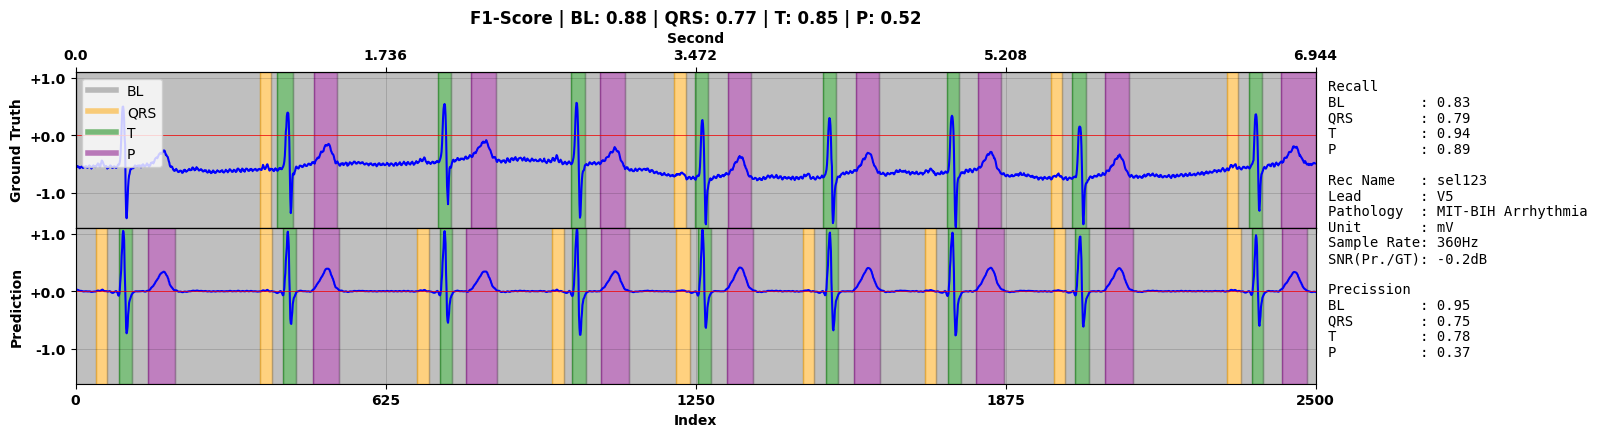

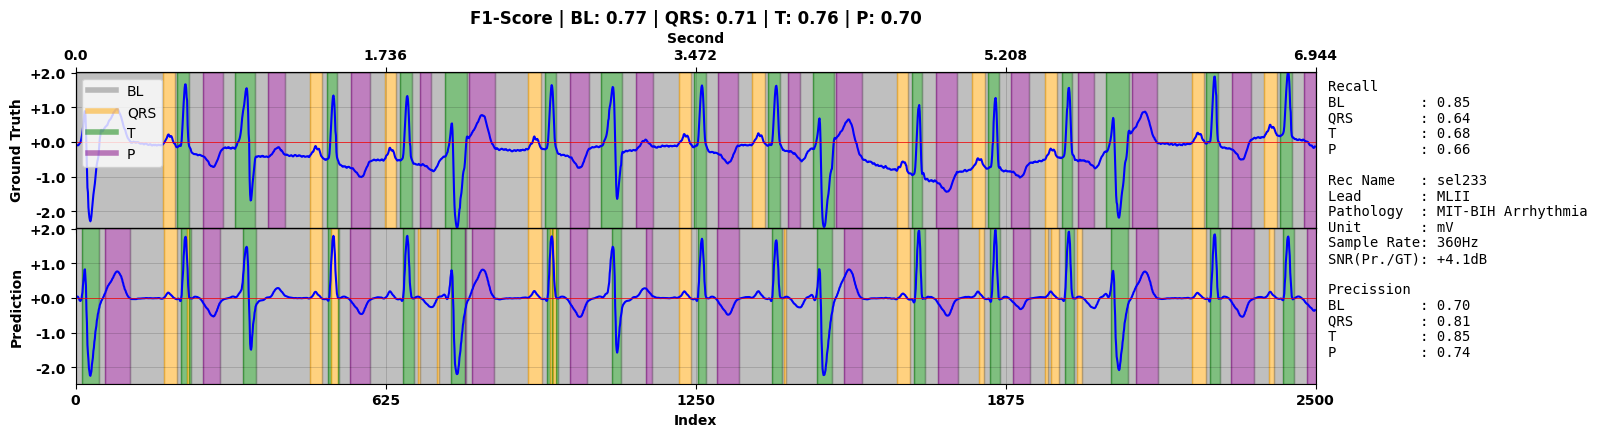

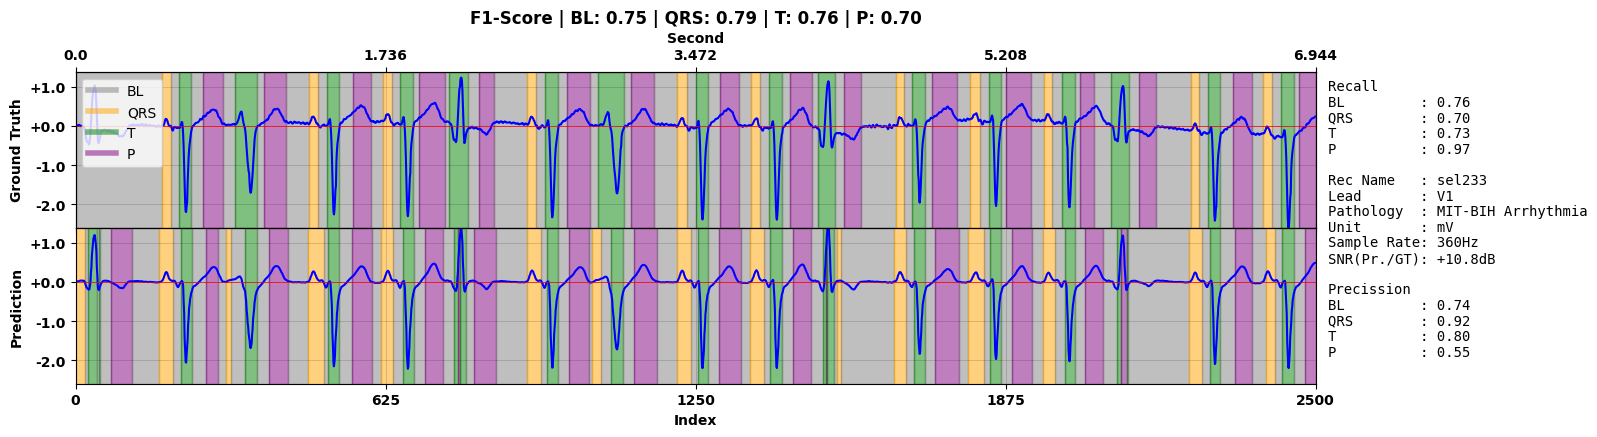

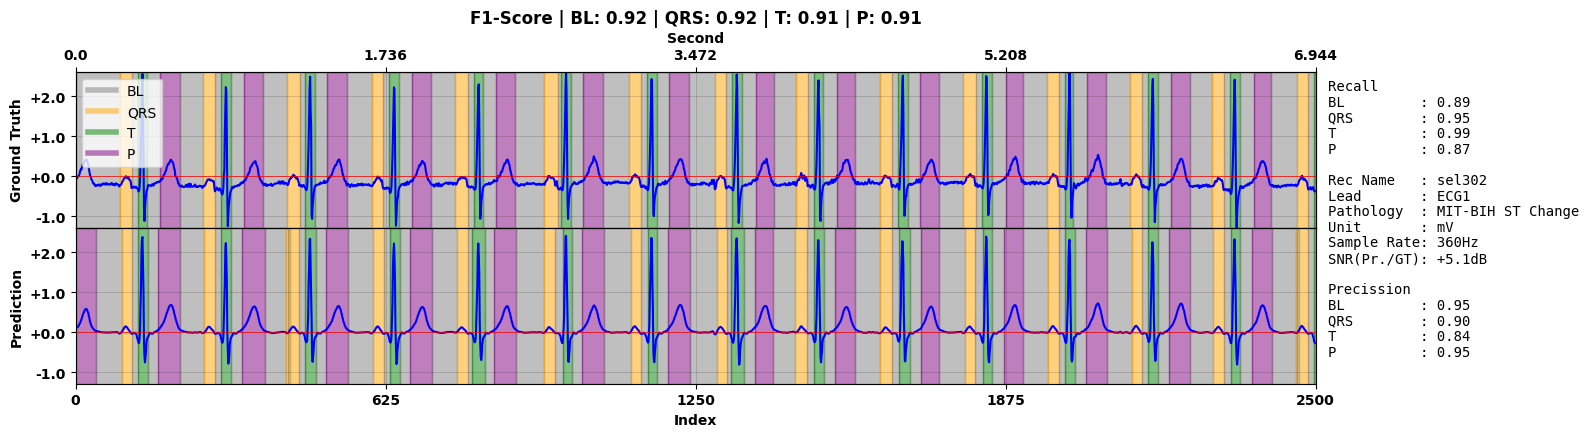

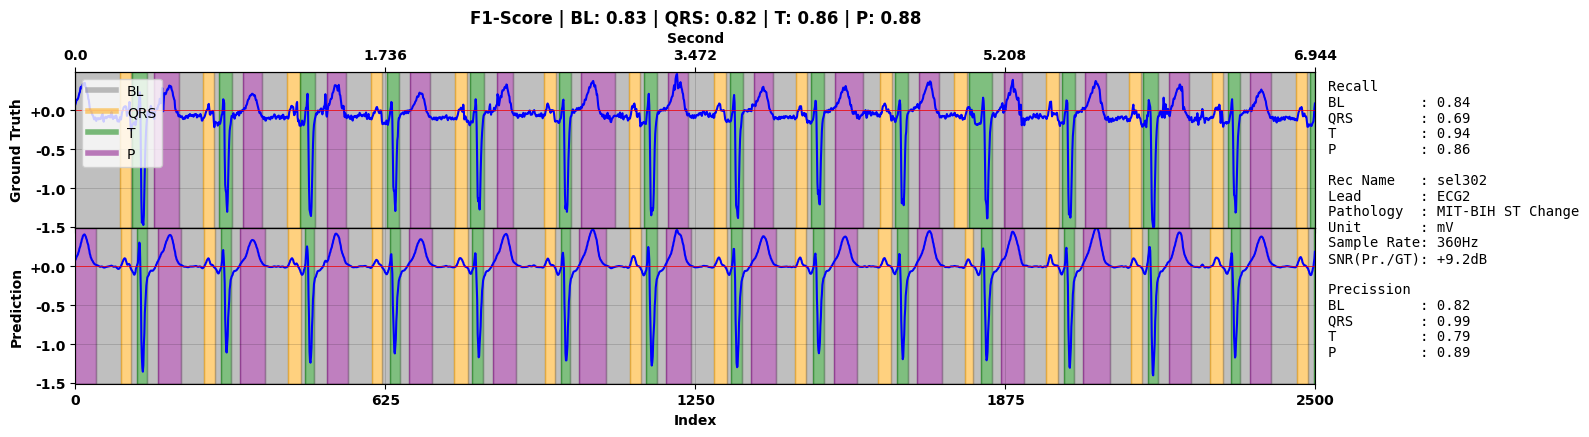

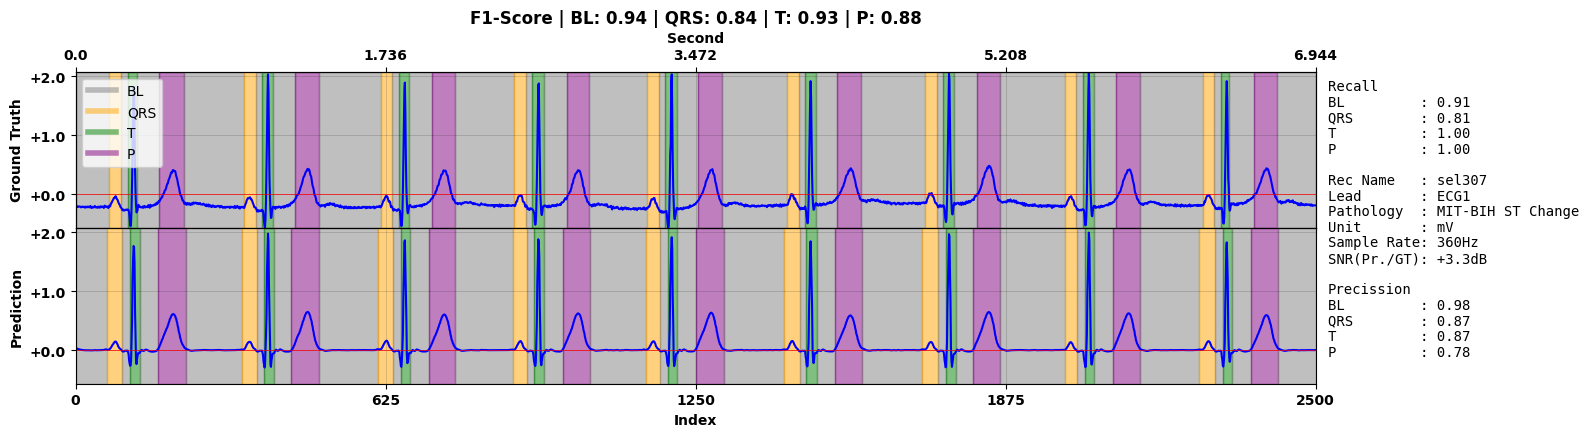

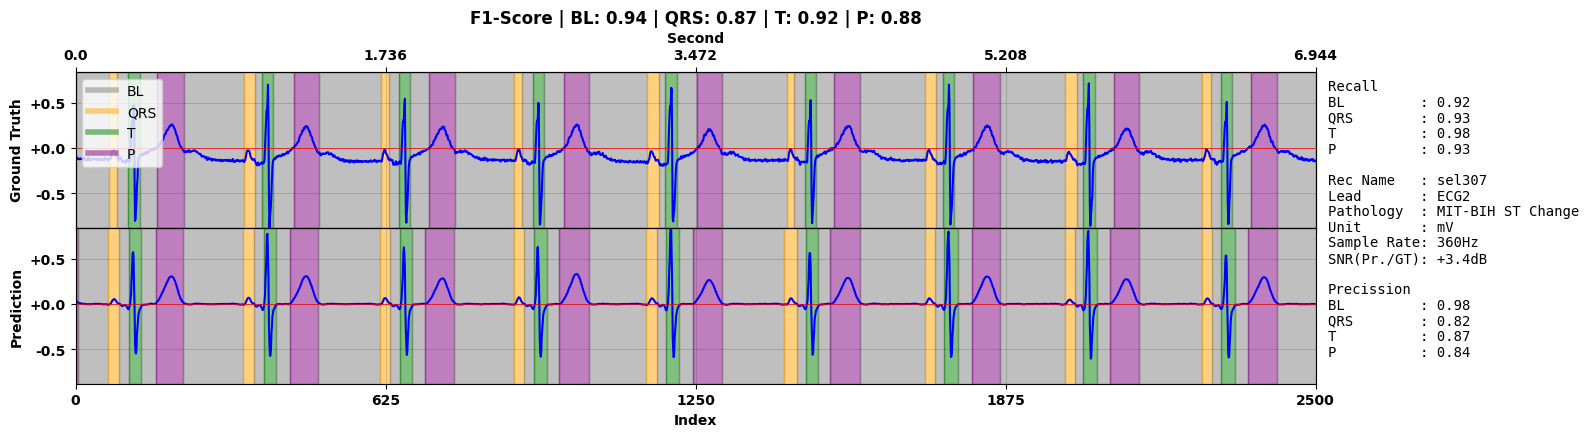

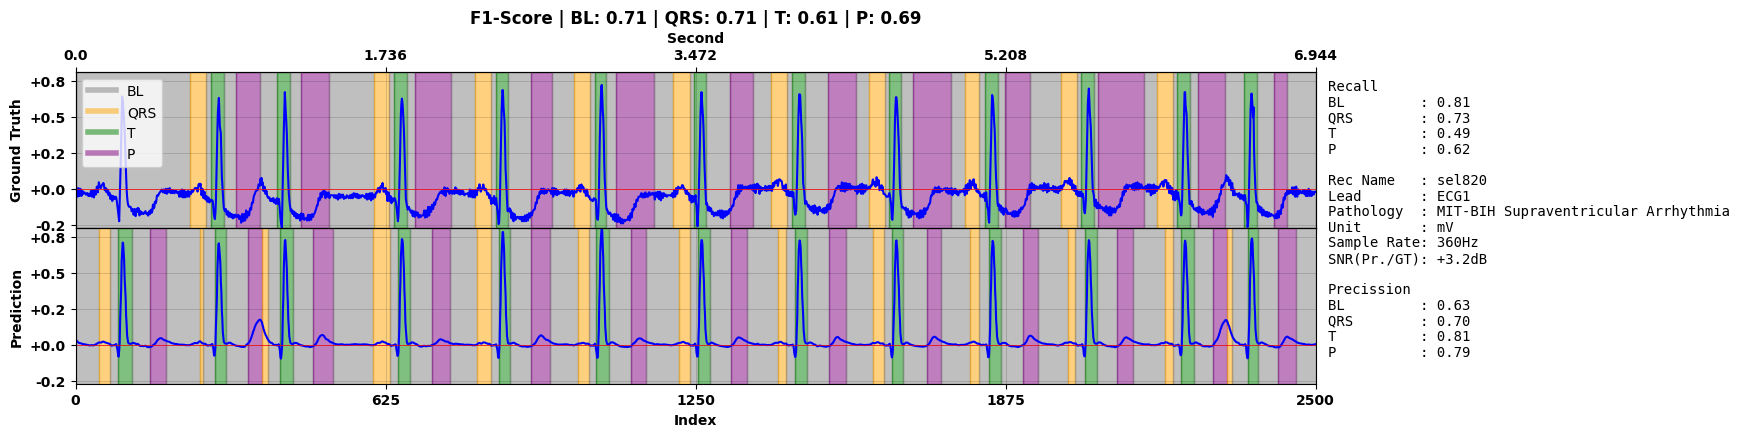

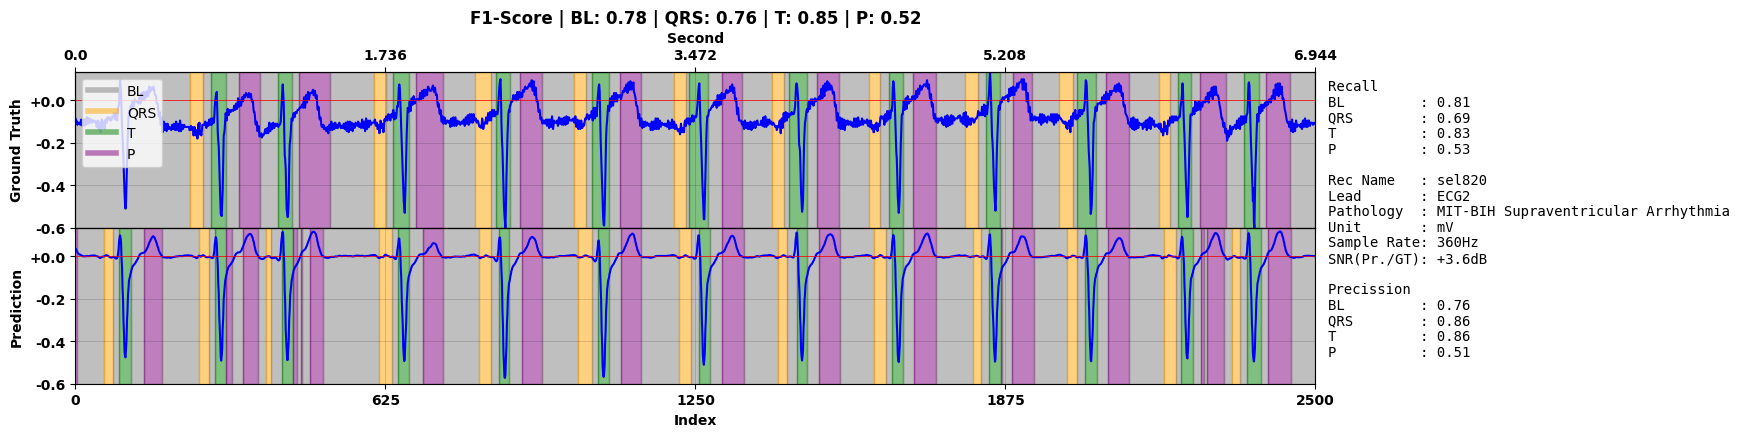

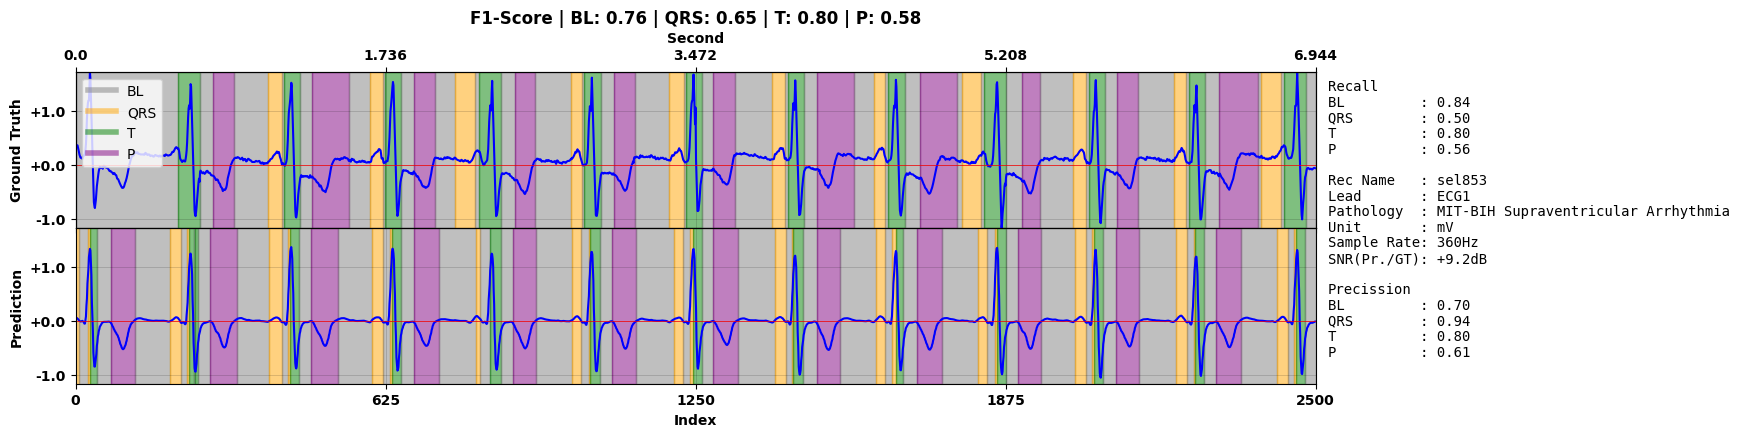

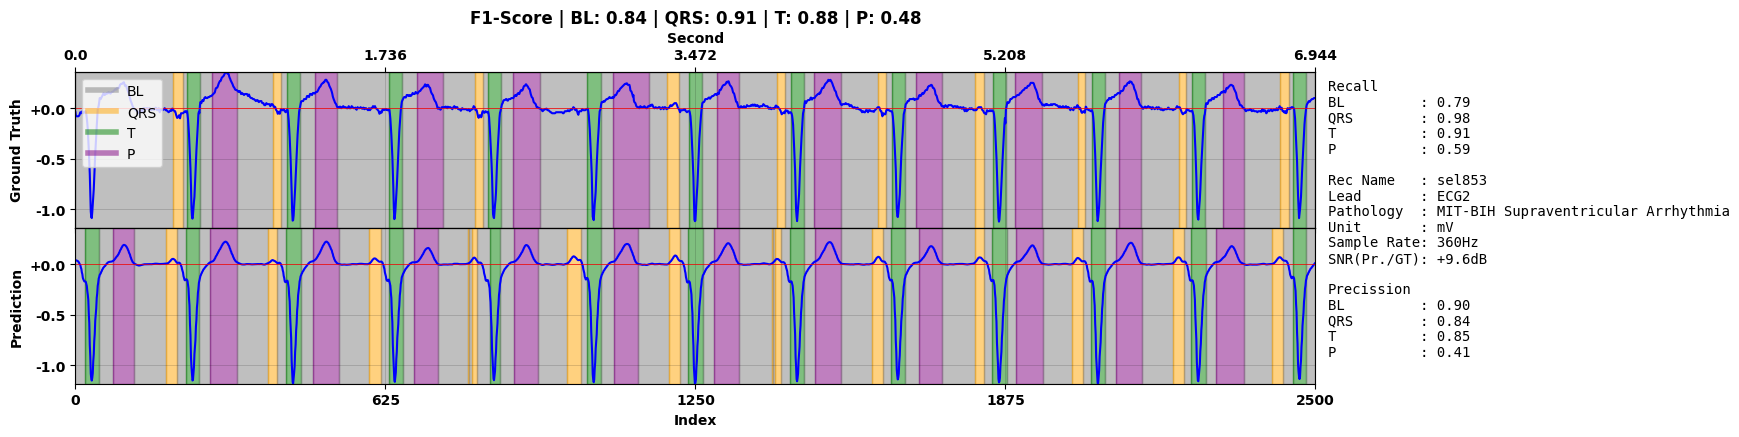

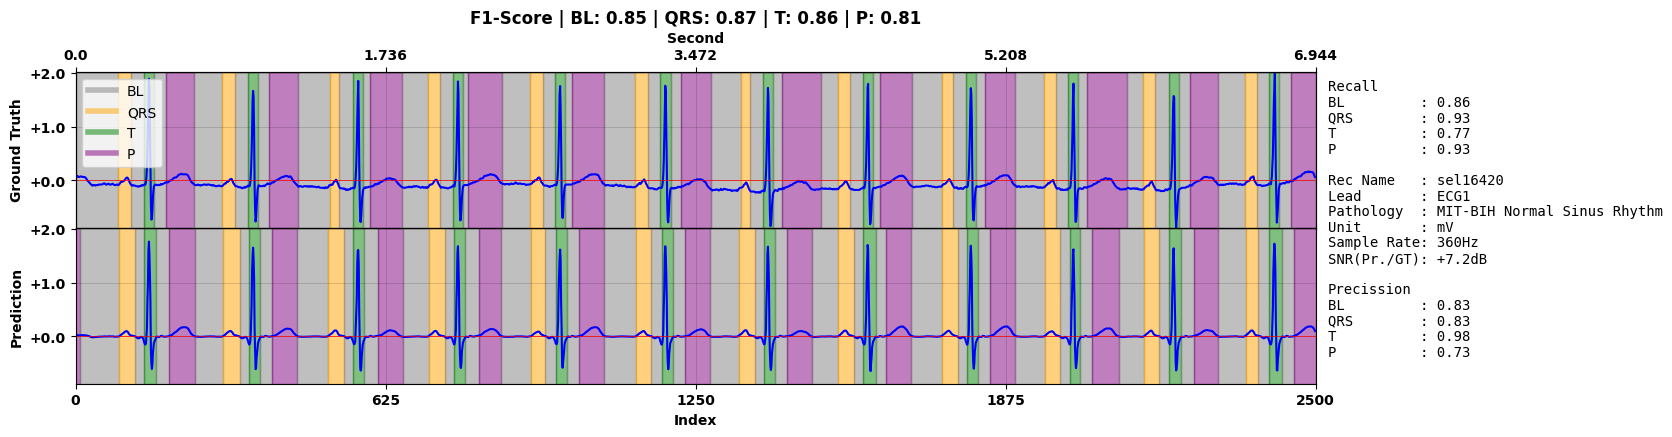

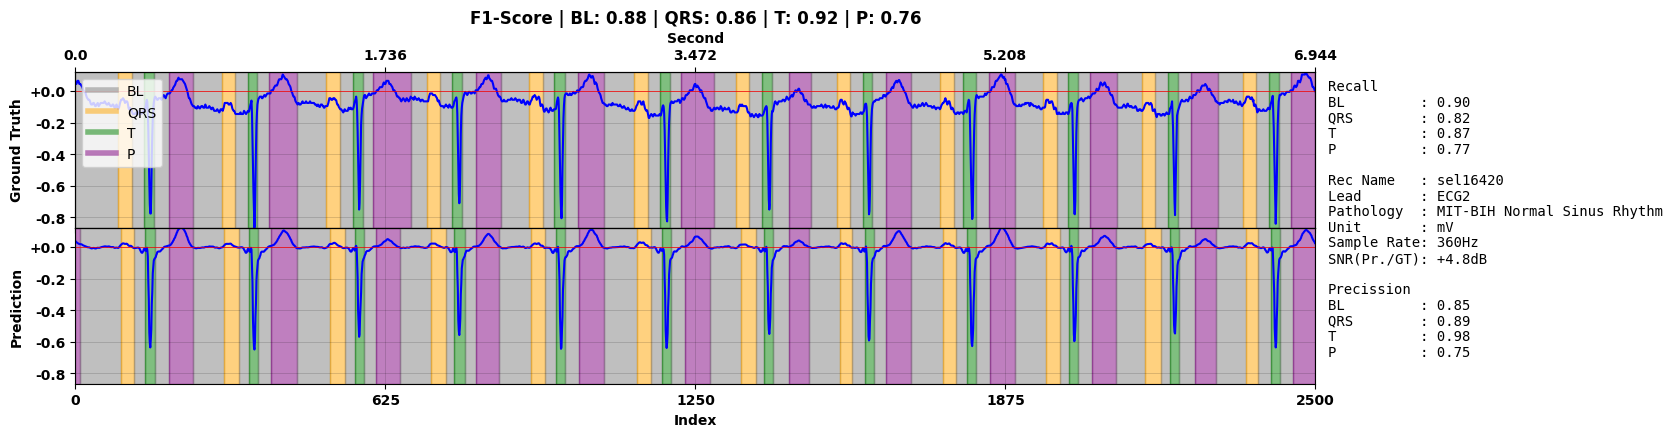

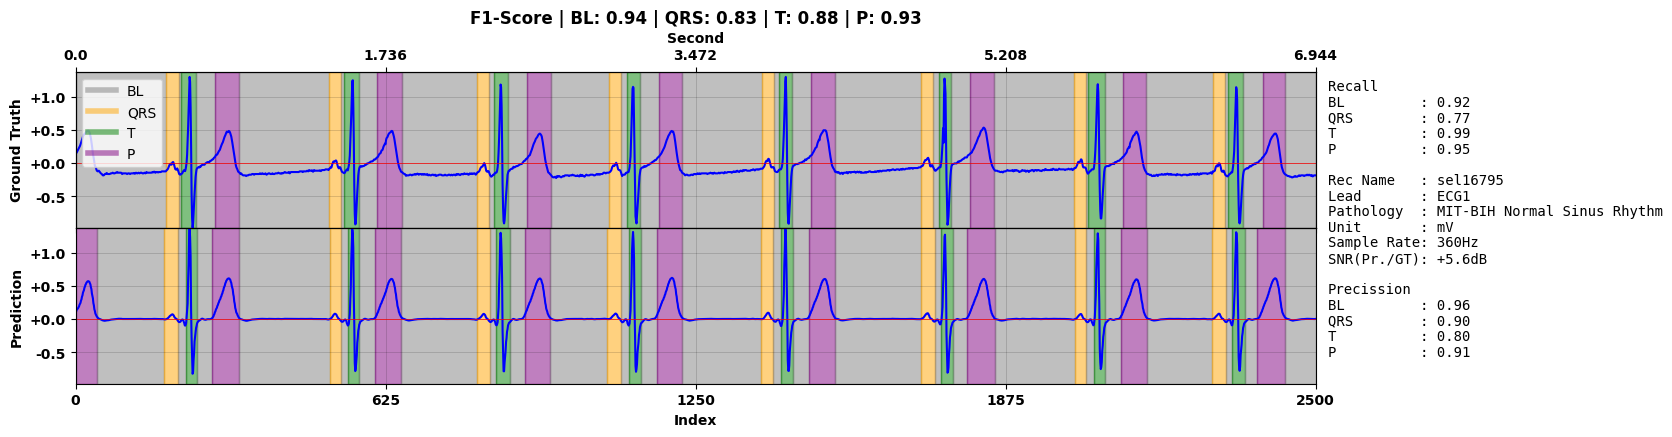

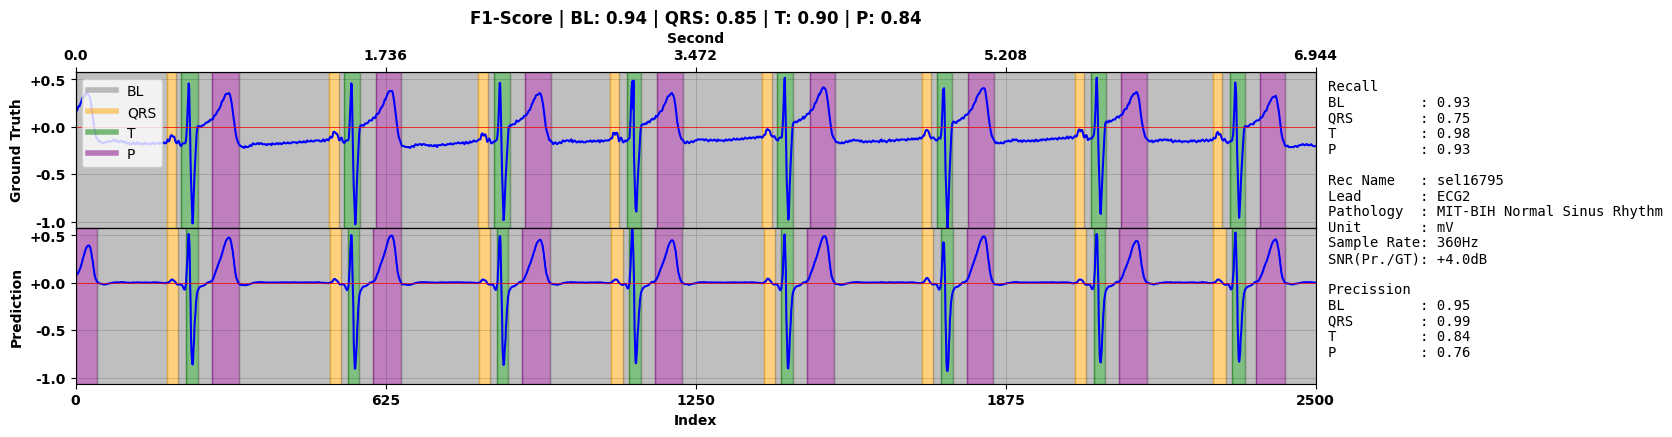

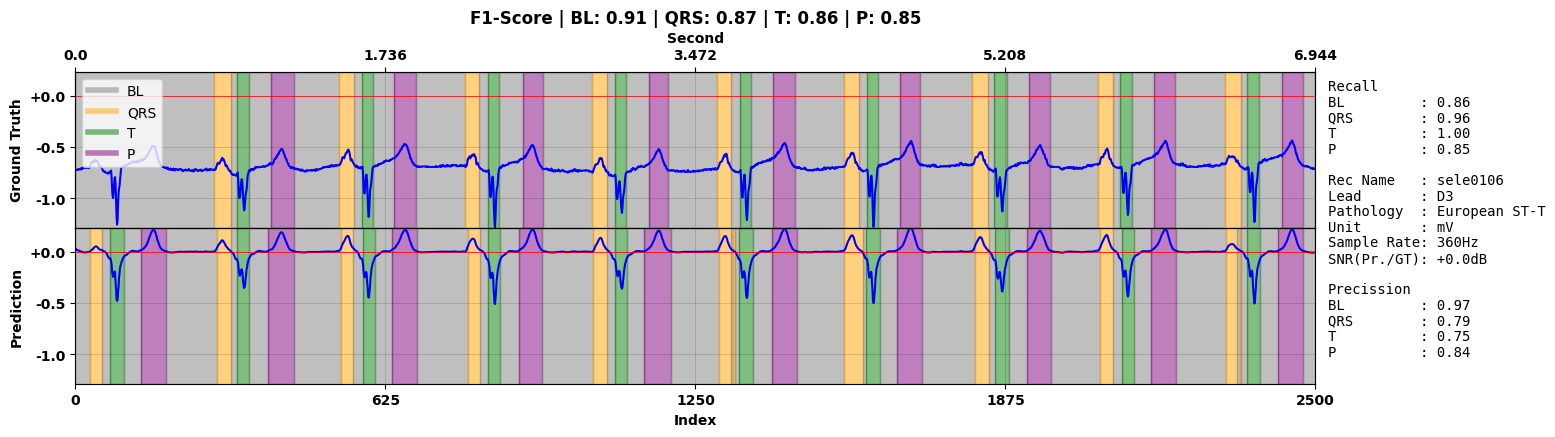

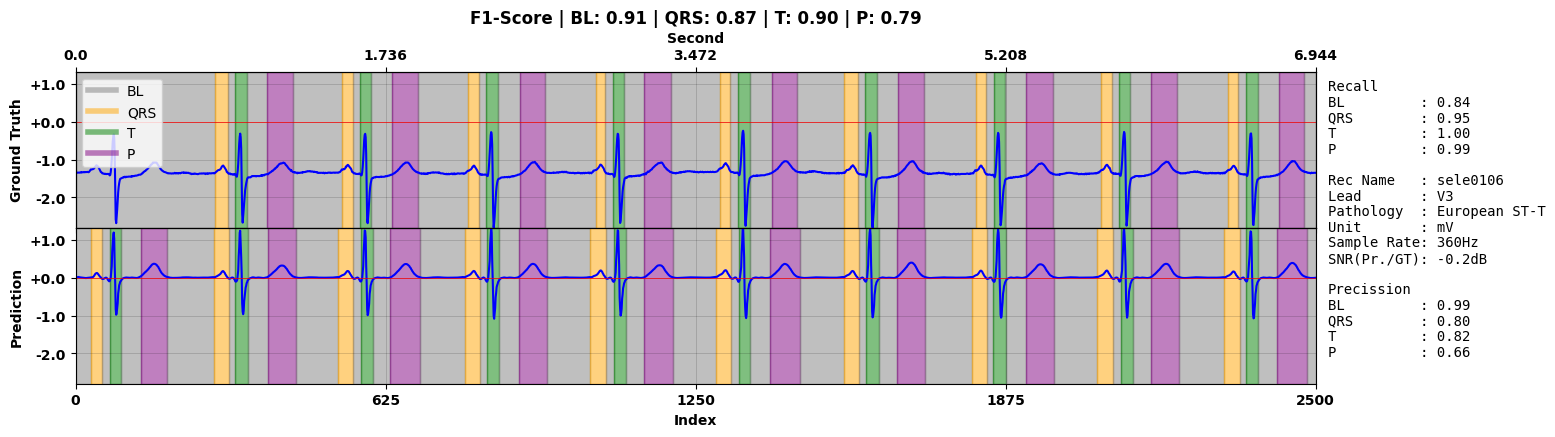

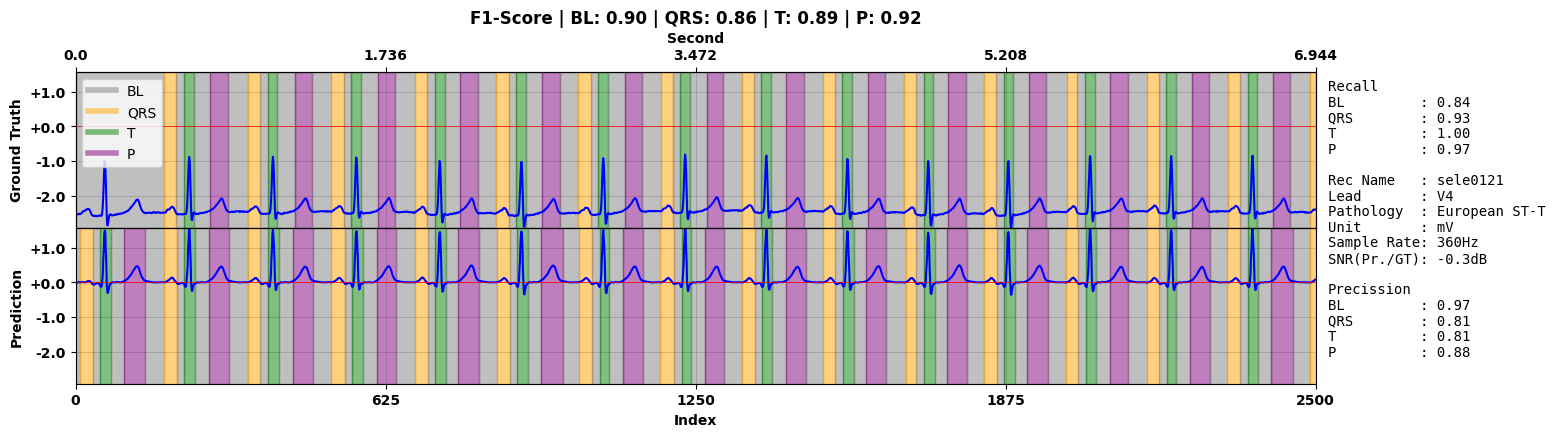

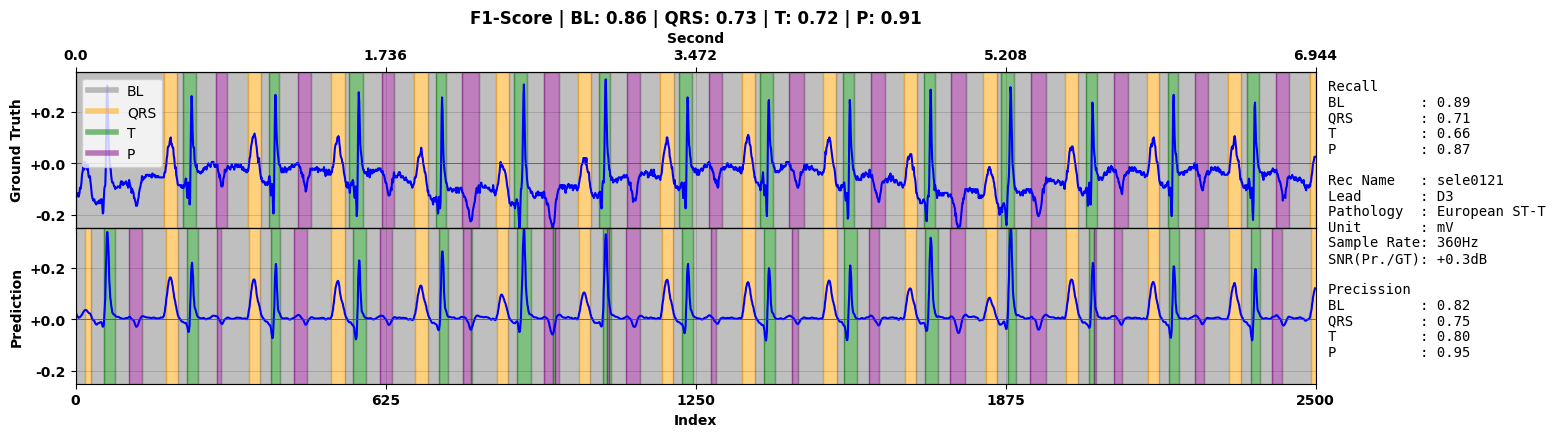

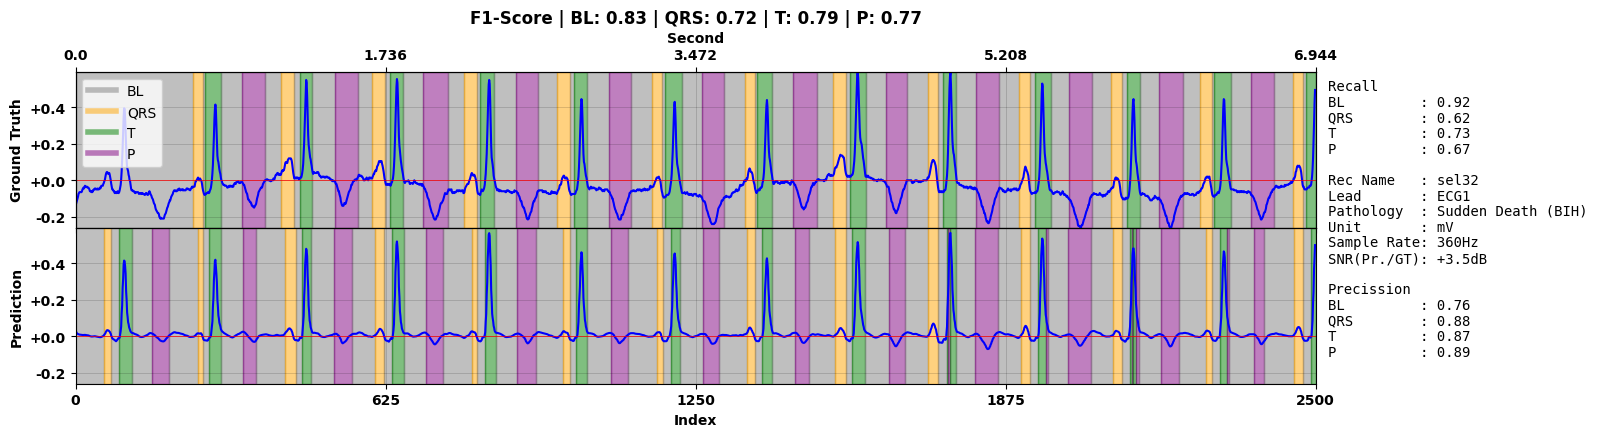

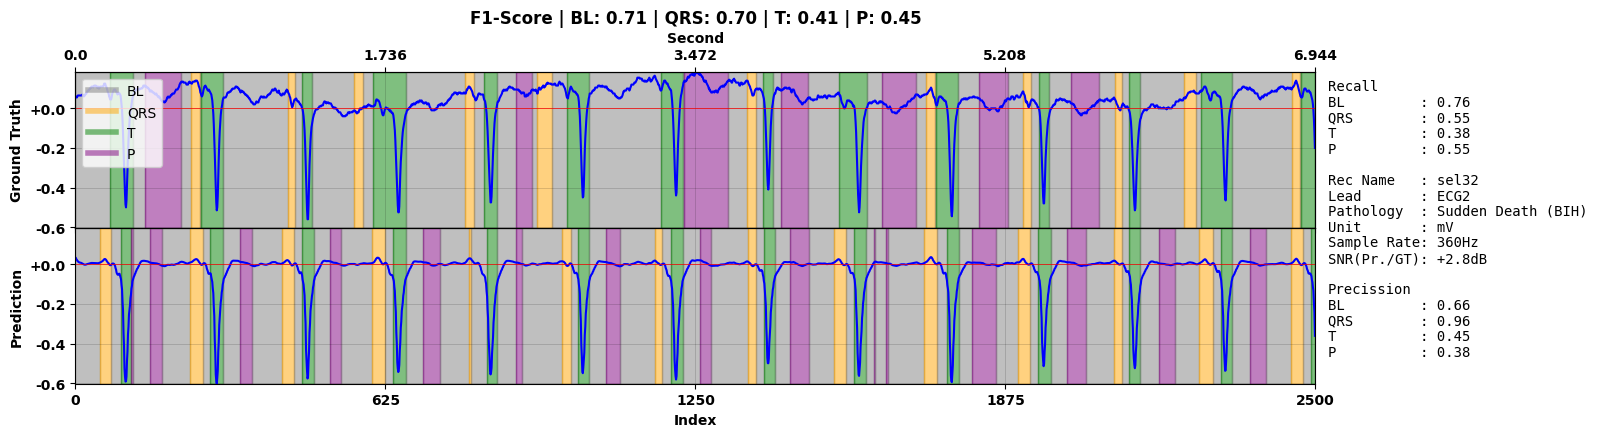

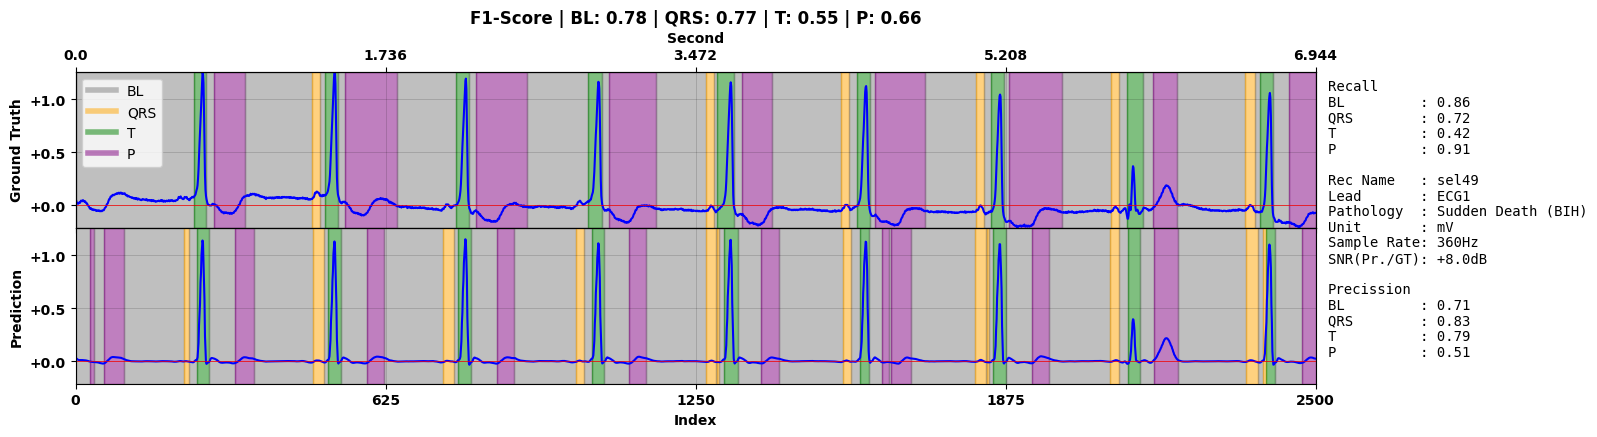

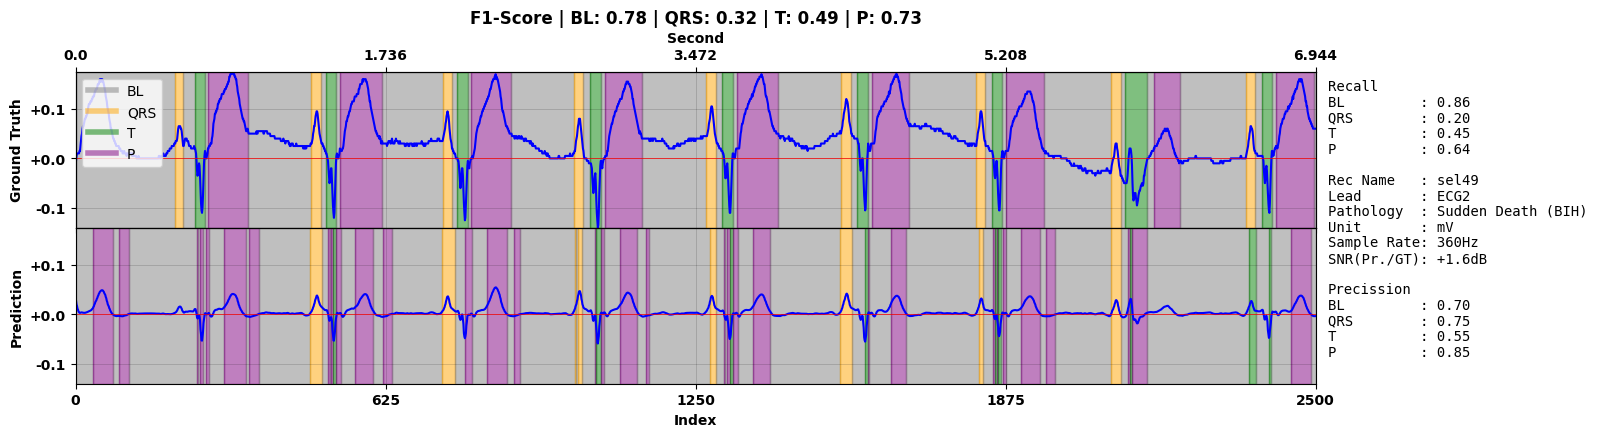

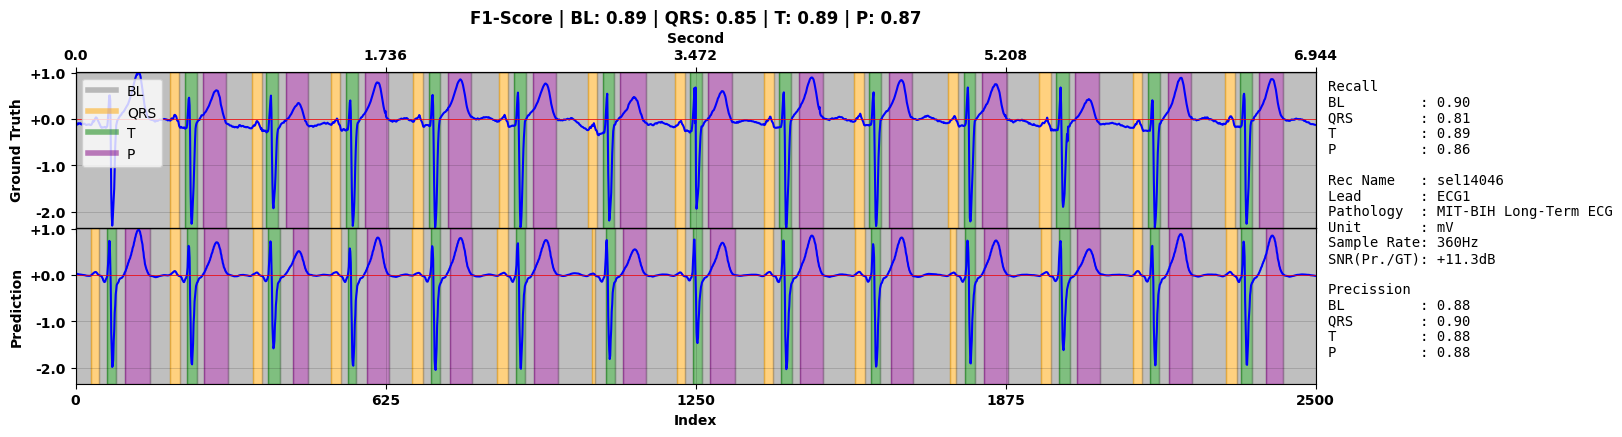

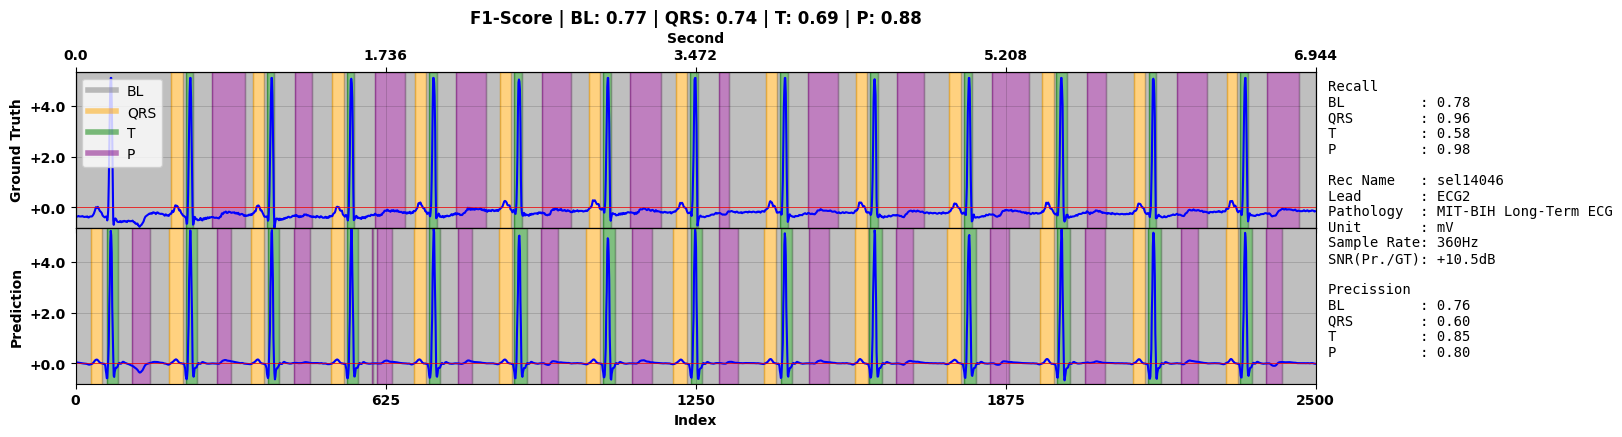

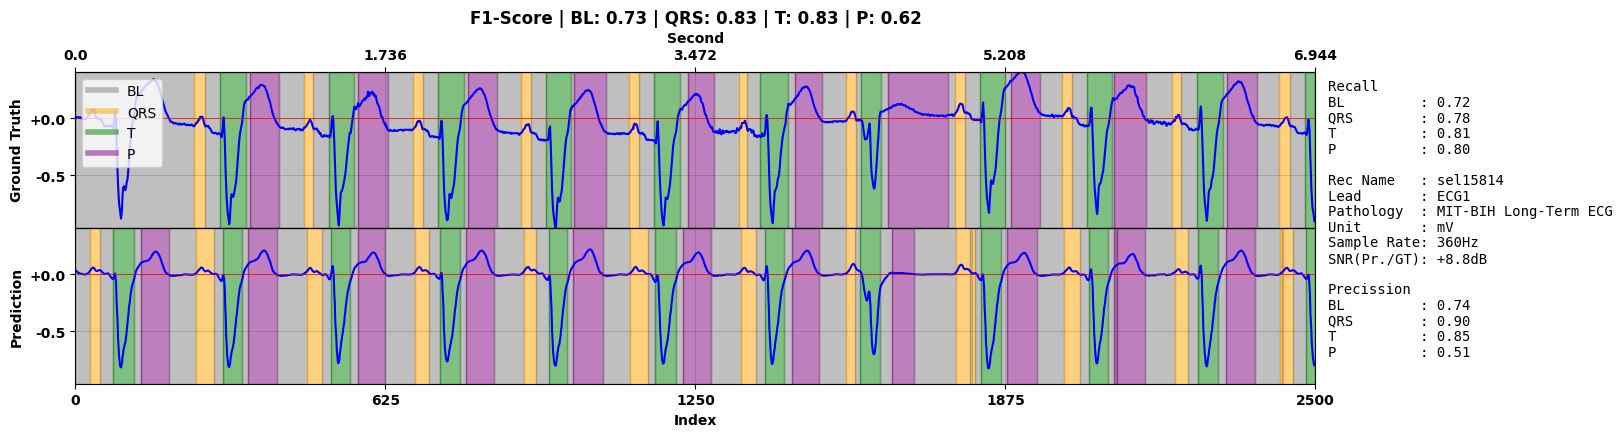

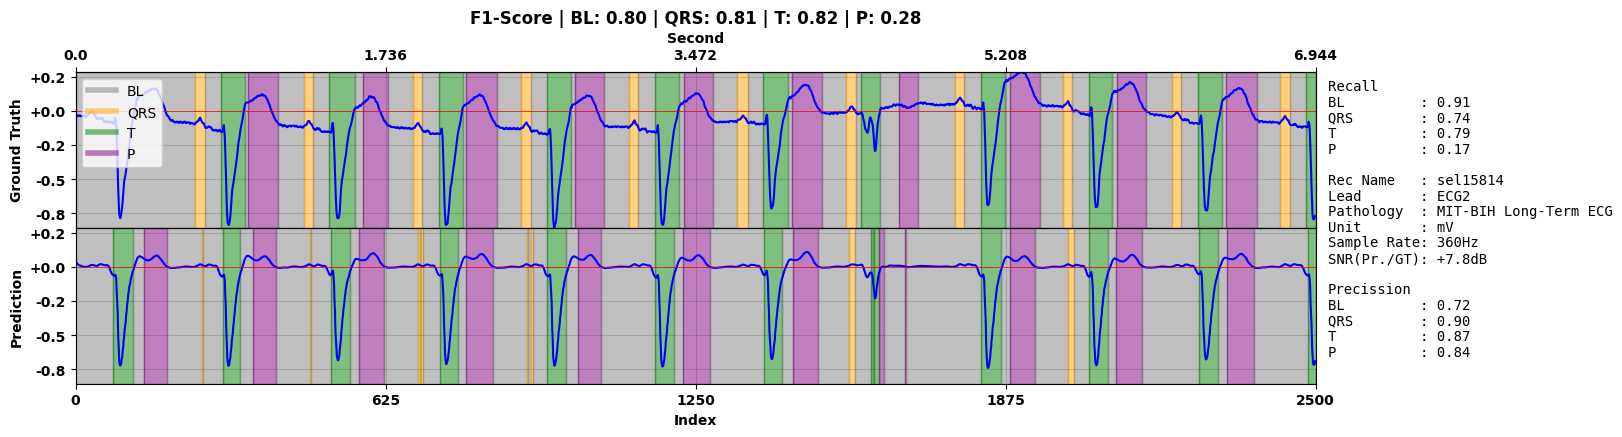

In [11]:
#@title QTDB Visualization
from visualizer import plot_delineation_comparison

for i in range(len(id_ref)):
  rec_name = id_ref[i]
  pathology_name = qtdb_pathology_mapping[rec_name]
  for l in range(2):
    lead_name = lead_ref_tensor[i,l]
    plot_delineation_comparison(X_gt[i,l,:], y_gt[i,l,:], X_pred[i,l,:], y_pred[i,l,:], rec_name=rec_name, pathology_name=pathology_name, lead_name=lead_name, start=0, stop=2500)
    print()

In [ ]:
#@title Eval per Subject

from metric_report import ExcelHandler
from pycm import ConfusionMatrix

handler = ExcelHandler()

for i in range(len(id_ref)):
  rec_name = id_ref[i]
  pathology_name = qtdb_pathology_mapping[rec_name]
  for l in range(2):
    lead_name = lead_ref_tensor[i,l]
    cm = ConfusionMatrix(actual_vector=y_gt[i,l,:].astype(int), predict_vector=y_pred[i,l,:].astype(int), transpose=True)
    handler.append(rec_name, lead_name, pathology_name, cm)
    print()

# Save the workbook again
handler.save(f'qtdb_pred_per_subject_{exp_name}.xlsx')

In [15]:
#@title Eval Overall

handler = ExcelHandler()

cm = ConfusionMatrix(actual_vector=y_gt.ravel().astype(int), predict_vector=y_pred.ravel().astype(int), transpose=True)
handler.append('QTDB OVERALL', '-', '-', cm)

# Save the workbook again
handler.save(f'qtdb_pred_overall_{exp_name}.xlsx')